In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.preprocessing import TimeSeriesDifferentiator

# Data set A

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


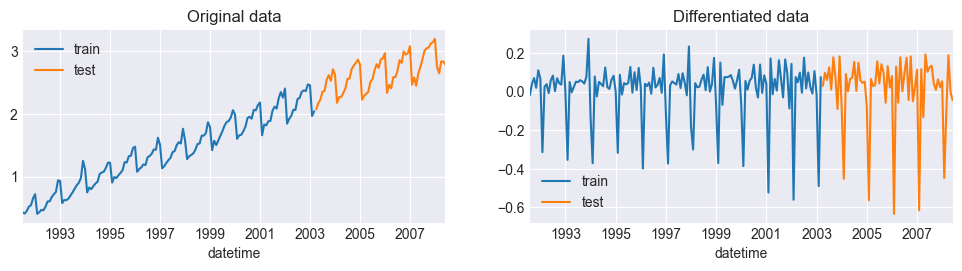

In [3]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(12, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

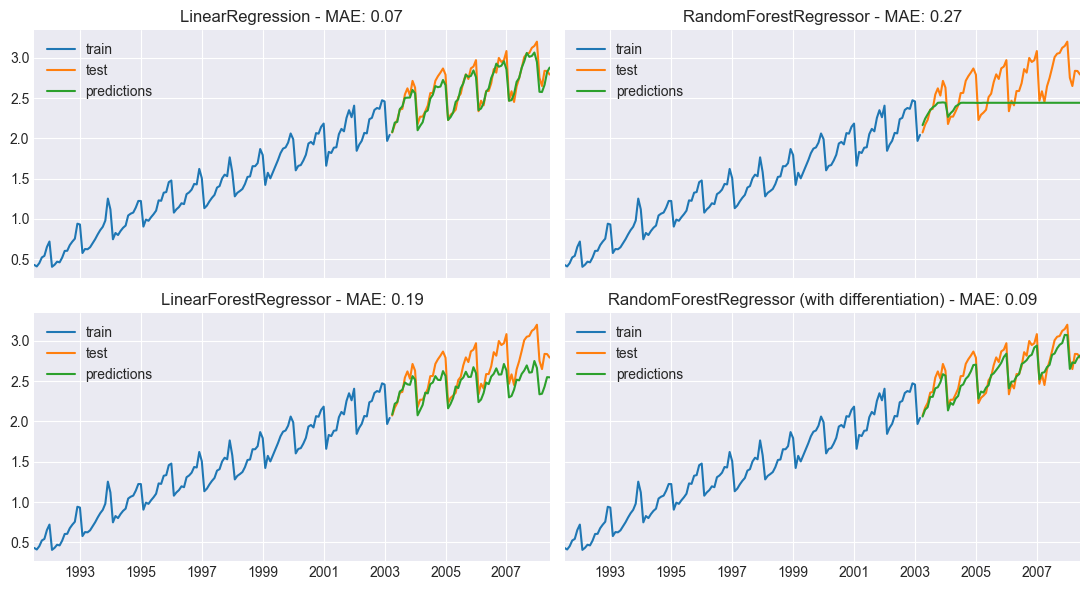

In [4]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=963),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]
steps = len(data.loc[end_train:])

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()
# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=15
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=steps)
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'{forecaster.regressor.__class__.__name__} - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoreg with random forest regressor and differentiation
forecaster = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'{forecaster.regressor.__class__.__name__} (with differentiation) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

Series differentiated before training
-------------------------------------
Last window of training series: datetime
2002-01-01    0.143554
2002-02-01   -0.560283
2002-03-01    0.075580
2002-04-01    0.048697
2002-05-01    0.098076
2002-06-01   -0.005842
2002-07-01    0.175968
2002-08-01    0.016304
2002-09-01    0.098830
2002-10-01    0.023778
2002-11-01   -0.010180
2002-12-01    0.105980
2003-01-01   -0.014631
2003-02-01   -0.489849
2003-03-01    0.075037
Freq: MS, Name: no_name, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.226935,0.405651,-0.066357,0.500842,0.331471,-0.137147,0.189123,0.095512,-2.284978,0.392797,0.693431,0.058284,0.413279,0.208734,-0.213555
1992-12-01,0.176184,0.226935,0.405651,-0.066357,0.500842,0.331471,-0.137147,0.189123,0.095512,-2.284978,0.392797,0.693431,0.058284,0.413279,0.208734
1993-01-01,1.225323,0.176184,0.226935,0.405651,-0.066357,0.500842,0.331471,-0.137147,0.189123,0.095512,-2.284978,0.392797,0.693431,0.058284,0.413279


Predictions


2003-04-01    0.016332
2003-05-01    0.088279
2003-06-01    0.029373
2003-07-01    0.127176
2003-08-01    0.003358
                ...   
2008-02-01   -0.425133
2008-03-01    0.086704
2008-04-01   -0.014892
2008-05-01    0.062450
2008-06-01    0.033382
Freq: MS, Name: pred, Length: 63, dtype: float64

2003-04-01    2.059665
2003-05-01    2.147944
2003-06-01    2.177317
2003-07-01    2.304493
2003-08-01    2.307851
                ...   
2008-02-01    2.654647
2008-03-01    2.741350
2008-04-01    2.726458
2008-05-01    2.788909
2008-06-01    2.822290
Length: 63, dtype: float64


Series differentiated during training
-------------------------------------
Last window of training series: datetime
2001-12-01    2.262313
2002-01-01    2.405868
2002-02-01    1.845584
2002-03-01    1.921165
2002-04-01    1.969862
2002-05-01    2.067938
2002-06-01    2.062096
2002-07-01    2.238064
2002-08-01    2.254368
2002-09-01    2.353198
2002-10-01    2.376976
2002-11-01    2.366796
2002-12-01    2.472776
2003-01-01    2.458145
2003-02-01    1.968296
2003-03-01    2.043333
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.080140,0.126662,0.003792,0.151441,0.107352,-0.014635,0.070297,0.045929,-0.573743,0.123316,0.201575,0.036238,0.128648,0.075402,-0.034525
1992-12-01,0.066929,0.080140,0.126662,0.003792,0.151441,0.107352,-0.014635,0.070297,0.045929,-0.573743,0.123316,0.201575,0.036238,0.128648,0.075402
1993-01-01,0.340033,0.066929,0.080140,0.126662,0.003792,0.151441,0.107352,-0.014635,0.070297,0.045929,-0.573743,0.123316,0.201575,0.036238,0.128648


Predictions


2003-04-01    2.060819
2003-05-01    2.149907
2003-06-01    2.177972
2003-07-01    2.305102
2003-08-01    2.306787
                ...   
2008-02-01    2.602182
2008-03-01    2.685599
2008-04-01    2.676527
2008-05-01    2.739496
2008-06-01    2.769713
Freq: MS, Name: pred, Length: 63, dtype: float64

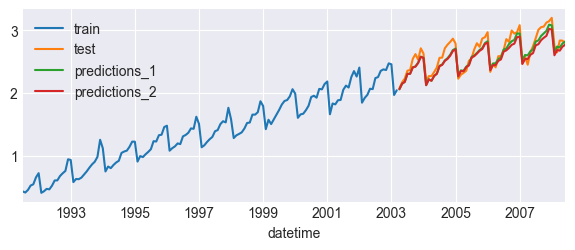

In [5]:
# Comparasion of results if the time series is differentiated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 transformer_y = StandardScaler()
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
last_window_1 = forecaster_1.last_window
print(f"Last window of training series: {last_window_1}")
print("Train matrix")
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff.loc[:end_train])
display(X_train_1.head(3))
predictions_diff = forecaster_1.predict(steps=steps)
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
print("Predictions")
display(predictions_diff)
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1,
                 transformer_y = StandardScaler()
             )

forecaster_2.fit(y=data.loc[:end_train])
last_window_2 = forecaster_2.last_window
print(f"Last window of training series: {last_window_2}")
print("Train matrix")
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))
predictions_2 = forecaster_2.predict(steps=steps)
print("Predictions")
display(predictions_2)

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions_1')
predictions_2.plot(ax=ax, label='predictions_2')
ax.legend();


In [6]:
pd.testing.assert_frame_equal(X_train_1, X_train_2, check_names=True)
pd.testing.assert_frame_equal(forecaster_1.get_feature_importances(), forecaster_2.get_feature_importances(), check_names=True)
pd.testing.assert_series_equal(predictions_1.asfreq('MS'), predictions_2, check_names=False)

AssertionError: DataFrame.iloc[:, 0] (column name="lag_1") are different

DataFrame.iloc[:, 0] (column name="lag_1") values are different (100.0 %)
[index]: [1992-11-01T00:00:00.000000000, 1992-12-01T00:00:00.000000000, 1993-01-01T00:00:00.000000000, 1993-02-01T00:00:00.000000000, 1993-03-01T00:00:00.000000000, 1993-04-01T00:00:00.000000000, 1993-05-01T00:00:00.000000000, 1993-06-01T00:00:00.000000000, 1993-07-01T00:00:00.000000000, 1993-08-01T00:00:00.000000000, 1993-09-01T00:00:00.000000000, 1993-10-01T00:00:00.000000000, 1993-11-01T00:00:00.000000000, 1993-12-01T00:00:00.000000000, 1994-01-01T00:00:00.000000000, 1994-02-01T00:00:00.000000000, 1994-03-01T00:00:00.000000000, 1994-04-01T00:00:00.000000000, 1994-05-01T00:00:00.000000000, 1994-06-01T00:00:00.000000000, 1994-07-01T00:00:00.000000000, 1994-08-01T00:00:00.000000000, 1994-09-01T00:00:00.000000000, 1994-10-01T00:00:00.000000000, 1994-11-01T00:00:00.000000000, 1994-12-01T00:00:00.000000000, 1995-01-01T00:00:00.000000000, 1995-02-01T00:00:00.000000000, 1995-03-01T00:00:00.000000000, 1995-04-01T00:00:00.000000000, 1995-05-01T00:00:00.000000000, 1995-06-01T00:00:00.000000000, 1995-07-01T00:00:00.000000000, 1995-08-01T00:00:00.000000000, 1995-09-01T00:00:00.000000000, 1995-10-01T00:00:00.000000000, 1995-11-01T00:00:00.000000000, 1995-12-01T00:00:00.000000000, 1996-01-01T00:00:00.000000000, 1996-02-01T00:00:00.000000000, 1996-03-01T00:00:00.000000000, 1996-04-01T00:00:00.000000000, 1996-05-01T00:00:00.000000000, 1996-06-01T00:00:00.000000000, 1996-07-01T00:00:00.000000000, 1996-08-01T00:00:00.000000000, 1996-09-01T00:00:00.000000000, 1996-10-01T00:00:00.000000000, 1996-11-01T00:00:00.000000000, 1996-12-01T00:00:00.000000000, 1997-01-01T00:00:00.000000000, 1997-02-01T00:00:00.000000000, 1997-03-01T00:00:00.000000000, 1997-04-01T00:00:00.000000000, 1997-05-01T00:00:00.000000000, 1997-06-01T00:00:00.000000000, 1997-07-01T00:00:00.000000000, 1997-08-01T00:00:00.000000000, 1997-09-01T00:00:00.000000000, 1997-10-01T00:00:00.000000000, 1997-11-01T00:00:00.000000000, 1997-12-01T00:00:00.000000000, 1998-01-01T00:00:00.000000000, 1998-02-01T00:00:00.000000000, 1998-03-01T00:00:00.000000000, 1998-04-01T00:00:00.000000000, 1998-05-01T00:00:00.000000000, 1998-06-01T00:00:00.000000000, 1998-07-01T00:00:00.000000000, 1998-08-01T00:00:00.000000000, 1998-09-01T00:00:00.000000000, 1998-10-01T00:00:00.000000000, 1998-11-01T00:00:00.000000000, 1998-12-01T00:00:00.000000000, 1999-01-01T00:00:00.000000000, 1999-02-01T00:00:00.000000000, 1999-03-01T00:00:00.000000000, 1999-04-01T00:00:00.000000000, 1999-05-01T00:00:00.000000000, 1999-06-01T00:00:00.000000000, 1999-07-01T00:00:00.000000000, 1999-08-01T00:00:00.000000000, 1999-09-01T00:00:00.000000000, 1999-10-01T00:00:00.000000000, 1999-11-01T00:00:00.000000000, 1999-12-01T00:00:00.000000000, 2000-01-01T00:00:00.000000000, 2000-02-01T00:00:00.000000000, 2000-03-01T00:00:00.000000000, 2000-04-01T00:00:00.000000000, 2000-05-01T00:00:00.000000000, 2000-06-01T00:00:00.000000000, 2000-07-01T00:00:00.000000000, 2000-08-01T00:00:00.000000000, 2000-09-01T00:00:00.000000000, 2000-10-01T00:00:00.000000000, 2000-11-01T00:00:00.000000000, 2000-12-01T00:00:00.000000000, 2001-01-01T00:00:00.000000000, 2001-02-01T00:00:00.000000000, ...]
[left]:  [0.22693476096824794, 0.1761835886117928, 1.2253227844633336, -0.1494200724194605, -2.566187062062115, 0.2682480056177091, -0.10474948022205181, 0.09439308341630769, 0.2790521838441624, 0.26371483161283515, 0.3349837051997272, 0.29171524357190803, 0.2099984645068287, 0.45733383356120444, 1.8392903359043342, -1.0200918989206977, -2.6905179657938243, 0.4699247118965162, -0.2608878026408928, 0.27159173138537307, 0.19865510251334187, 0.11290529346898777, 0.7948931345451224, 0.08088842235614062, 0.01593415673080917, 0.35168295459805177, 0.49486928107331823, -0.08229474779208812, -2.3127508206089926, 0.532153708665243, -0.18950953351955035, 0.2290195252900314, 0.18398212804001385, 0.2291176863665149, 0.8157503972676012, -0.11930112254934157, 0.624256603689694, -0.023303240947878306, 0.780221213302227, 0.063879242348665, -2.87910765198737, 0.20399680641499882, 0.11941137872351631, 0.24947852647759428, -0.15632687674658496, 0.7867237877886422, 0.07174771627772622, 0.16357698203532833, 0.4143137938851713, -0.12525039998090262, 1.271050960447572, -0.8831767873130955, -2.7000355177216546, 0.13990675146874632, 0.2897096821787878, 0.22997354141748208, 0.1734927252827114, 0.5574024507914904, 0.049066609519737535, 0.5861337344566535, 0.2471789733625628, -0.2157514017300455, 1.5611834354027068, -1.3717988230372842, -2.1872962604345396, 0.22697471350939197, 0.07524430088909577, 0.09771019756166373, 0.3493202076569573, 0.5361256512793232, -0.03296824513652056, 0.8095271394923788, -0.08281216479681117, 0.18859513691181323, 1.145902960544882, -0.6050885640978371, -2.681600404136771, 0.9744112065767493, -0.5655479764847765, 0.4475298731705884, 0.4431164163584205, 0.4581628663437734, 0.5196805112771323, 0.3160936662825585, 0.025598528981191526, 0.33601938179352037, 0.7155037138785428, -0.5798165104713088, -2.793795074004, 0.30677131306189726, -0.007277005797114545, 0.31377992966434315, 0.41978715159112373, 0.8974893643871638, 0.06034361799585721, -0.2967352728435289, 0.9032989834631269, -0.12884753299107465, 0.5118923637225319, 0.20541965051646463, ...]
[right]: [0.08013990073710131, 0.06692871579633075, 0.34003318415533546, -0.017830118010760287, -0.646945745816689, 0.09089427133043215, -0.006201786535208864, 0.045637592057409915, 0.09370673831504073, 0.08971422765131387, 0.10826643493558663, 0.09700309613716707, 0.07573116426118287, 0.14011575187269365, 0.4998568590204022, -0.2444772275954752, -0.6793106841380361, 0.14339331994710647, -0.046846606310580796, 0.0917646862875009, 0.07277834078562828, 0.050456559173097215, 0.22798679300753977, 0.04212215455036672, 0.025213721187663518, 0.11261346500267161, 0.1498867131311688, -0.00035652997947466236, -0.5809730224081607, 0.1595923306658351, -0.02826592195730193, 0.08068259178706472, 0.06895877622391056, 0.08070814438171814, 0.23341620758834125, -0.009989766773921771, 0.1835679025245928, 0.01499972034277934, 0.22416750261529222, 0.03769444554708819, -0.7284030125817139, 0.0741688552282892, 0.05215017710440917, 0.0860083337520769, -0.01962804828662612, 0.22586020664836937, 0.03974271082751056, 0.06364705345782486, 0.12891708051338924, -0.011538440445148013, 0.3519368183352271, -0.208836457606362, -0.6817882256974472, 0.05748538705513695, 0.09648102263138697, 0.08093093449346975, 0.06622824935506036, 0.166164903992986, 0.03383852611357783, 0.1736440278134218, 0.08540973040809041, -0.03509701881719701, 0.4274620447681137, -0.33603107756014, -0.5483155818176892, 0.08015030089901679, 0.040652916913734655, 0.046501079665856475, 0.1119984114904532, 0.16062627857309097, 0.012483795057494113, 0.23179621329884784, -0.000491220301362838, 0.07015960194889515, 0.3193591793386441, -0.1364465052926842, -0.6769893277870026, 0.2747176632456284, -0.1261535801962171, 0.13756365449526345, 0.1364147747459617, 0.1403315598019284, 0.1563453964602628, 0.10334911409183833, 0.02772948197126668, 0.10853603491493946, 0.20732070254956425, -0.12986786368125203, -0.706195047855381, 0.10092238527429842, 0.019171556118196376, 0.10274681859898177, 0.1303418661398662, 0.2546939153011709, 0.036774076912488685, -0.05617816529762243, 0.2562062341006047, -0.012474820576825696, 0.15431804117145953, 0.07453923990500799, ...]
At positional index 0, first diff: 0.22693476096824794 != 0.08013990073710131

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>



</div>

In [ ]:
# Compare bootstrapping prediction if the time series is differenciated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
boot_predictions_diff = forecaster_1.predict_bootstrapping(
                            steps=steps,
                            n_boot=10
                        )
last_value_train = data.loc[:end_train].iloc[[-1]]

boot_predictions_1 = boot_predictions_diff.copy()
boot_predictions_1.loc[last_value_train.index[0]] = last_value_train.values[0]
boot_predictions_1 = boot_predictions_1.sort_index()
boot_predictions_1 = boot_predictions_1.cumsum(axis=0).iloc[1:,]
print("Predictions")
display(boot_predictions_diff.head(3))
print("Predictions undifferentiated")
display(boot_predictions_1.head(3))
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
               )

forecaster_2.fit(y=data.loc[:end_train])
boot_predictions_2 = forecaster_2.predict_bootstrapping(
                        steps=steps,
                        n_boot=10
                     )
print("Predictions")
display(boot_predictions_2.head(3))

Series differentiated before training
-------------------------------------
Predictions


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,0.030295,0.032775,-0.002842,0.014901,0.043229,0.001341,0.001325,0.010020,0.040975,0.019096
2003-05-01,0.060069,0.053095,0.082596,0.083665,0.070504,0.086381,0.066698,0.084330,0.087346,0.109301
2003-06-01,0.046608,0.036182,0.037772,0.054342,0.025494,0.037961,0.060449,0.040089,0.022522,0.021476


Predictions undifferentiated


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,2.073628,2.076108,2.040491,2.058234,2.086562,2.044674,2.044659,2.053353,2.084308,2.062429
2003-05-01,2.133696,2.129204,2.123086,2.141899,2.157067,2.131055,2.111357,2.137683,2.171655,2.171730
2003-06-01,2.180305,2.165386,2.160859,2.196241,2.182561,2.169016,2.171806,2.177772,2.194176,2.193207



Series differentiated during training
-------------------------------------
Predictions


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,2.073628,2.076108,2.040491,2.058234,2.086562,2.044674,2.044659,2.053353,2.084308,2.062429
2003-05-01,2.133696,2.129204,2.123086,2.141899,2.157067,2.131055,2.111357,2.137683,2.171655,2.171730
2003-06-01,2.180305,2.165386,2.160859,2.196241,2.182561,2.169016,2.171806,2.177772,2.194176,2.193207


In [ ]:
boot_predictions_1 = boot_predictions_1.asfreq(boot_predictions_2.index.freq)
pd.testing.assert_frame_equal(boot_predictions_1, boot_predictions_2)

In [ ]:
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff.loc[:end_train])
display(X_train_1.head(3))

forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 2
             )
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))



,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558


# Data set B

Train dates : 1949-01-01 00:00:00 --- 1956-01-01 00:00:00  (n=85)
Test dates  : 1956-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=60)


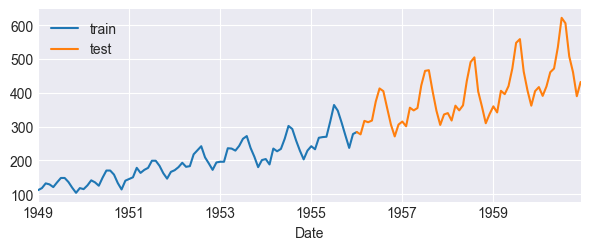

In [ ]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()


# # Data partition train-test
# # ==============================================================================
end_train = '1956-01-01'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

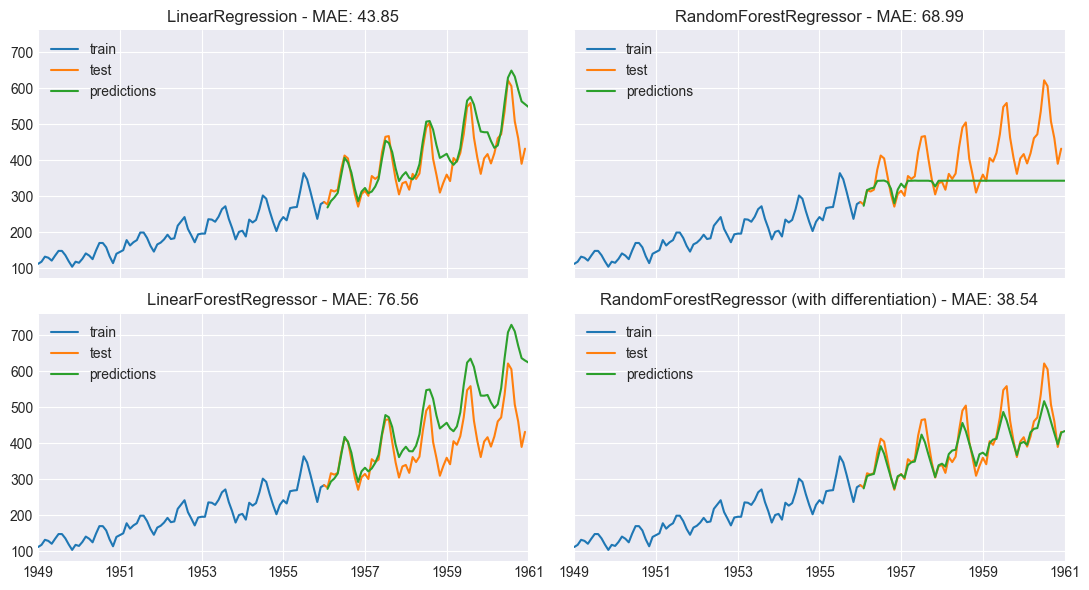

In [ ]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]

steps = len(data.loc[end_train:])

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()

# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=12
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=len(data.loc[end_train:]))
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'{regressor.__class__.__name__} - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoreg with random forest regressor and differentiation
forecaster = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=123),
                 lags            = 12,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'{forecaster.regressor.__class__.__name__} (with differentiation) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

c:\anaconda\envs\skforecast_09_py11\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Predictions Sarimax


1956-02-01    271.574028
1956-03-01    294.911618
1956-04-01    298.129025
1956-05-01    301.076074
Freq: MS, Name: predicted_mean, dtype: float64

Predictions Forecaster


1956-02-01    266.623558
1956-03-01    292.217417
1956-04-01    295.933849
1956-05-01    299.376789
Freq: MS, Name: pred, dtype: float64

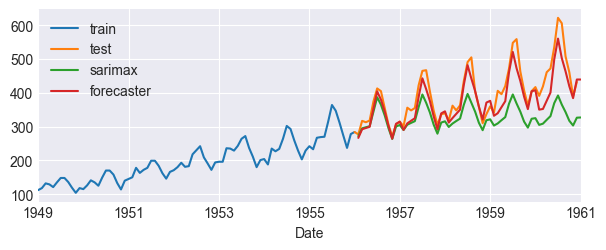

In [ ]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 1, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
print("Predictions Sarimax")
display(predictions_sarimax.head(4))

forecaster = ForecasterAutoreg(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 1
            )
            
forecaster.fit(y=data.loc[:end_train])
print("Predictions Forecaster")
predictions = forecaster.predict(steps=steps)
display(predictions.head(4))

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecaster')
ax.legend();
